<a href="https://colab.research.google.com/github/33quitykubby/python_test/blob/feature%2Ftest/Lemon_0227_3_EfficientNetB7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ひろしまQuest2020：画像データを使ったレモンの外観分類**  

https://signate.jp/competitions/362/data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 日本時間にする

In [ ]:
  !rm /etc/localtime
  !ln -s /usr/share/zoneinfo/Asia/Tokyo /etc/localtime
  !date

Sat Feb 27 17:43:58 JST 2021


# ライブラリのインポート

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import os
import glob

import librosa

import datetime

import gc

In [ ]:
#開始時刻
start_time = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
print("start_time=",start_time)

start_time= 2021-02-27 17:44:01.608284+09:00


# 乱数シードの初期化

【参考】gpuの順序性（tensorflowのバージョンが書かれているものと違うため適用していない)  
https://qiita.com/Rin-P/items/acacbb6bd93d88d1ca1b　　


[TensorFlow 2.x (tf.keras)] 乱数シードを固定して再現性を向上  
以下の記事によると  
「モデルインスタンス生成 (Sequentialやfunctional APIやSubClassの利用) の直前にtf.random.set_seedを呼ぶようにすると、生成されたモデルは毎回同じ初期値をもってくれます。」  
とのこと→あまり効いてないかも  
https://qiita.com/bee2/items/08eab7a899c9ff56eb35


https://qiita.com/temple1026/items/05546696f5dc9828e270





In [ ]:
import os 
import numpy as np
from sklearn import model_selection
import tensorflow as tf
import random

COMMON_SEED = 0
STANDARD_SEED = 0
NP_SEED = 0
TF_SEED = 0 

# np.random.seed(STANDARD_SEED)
# random.seed(NP_SEED)
# tf.random.set_seed(TF_SEED)

def seed_everything():
    random.seed(STANDARD_SEED)
    os.environ['PYTHONHASHSEED'] = str(COMMON_SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    np.random.seed(NP_SEED)
    tf.random.set_seed(TF_SEED)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)


In [ ]:
#乱数シード固定

seed_everything()

# パス定義

In [ ]:
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/SIGNATE_LEMON/new_data/'

TRAIN_FILE_PATH =  BASE_PATH + 'train_crop_5/'
TEST_FILE_PATH_A =  BASE_PATH + 'test_crop_5/'
# TEST_SAMPLE_FILE_PATH =  BASE_PATH + 'test_crop/'

OUTPUT_PATH='/content/drive/MyDrive/SIGNATE/Lemon/'

STR_MODEL='EfficientB7'

#エポック
EPOCH = 82

# バッチサイズ
BATCH_SIZE = 80

# 学習率
LEARNING_RATE = 2e-3

# 画像サイズ
IMAGE_SIZE = 600 # Specified size

# 重複実行のためのID
STR_ID = "2"


# ImageDataGeneratorを使う 学習データ定義
[学習済みモデルの比較と前処理](https://qiita.com/taichinakabeppu/items/ae5a1b594a2e9b1196eb)  
[ディープラーニング　脱超初心者向け基礎知識](https://qiita.com/gal1996/items/00ed3589e13448496b4c)  
[ImageDataGeneratorクラス](https://keras.io/ja/preprocessing/image/)  


In [ ]:
import numpy as np
from sklearn import model_selection
import tensorflow as tf
import random

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from tensorflow.keras import models, layers
from tensorflow.keras.applications import EfficientNetB7

#乱数シード固定
seed_everything()

classes = ['0_Exellent', '1_Good', '2_ForProcess', '3_NonRegular']
num_classes = len(classes)

X = [] # image file
Y = [] # correct label

#DataGeneratorのインスタンス化
# train, validation 用
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    # rotation_range=180, #180度回転
    # zoom_range = 0.1,   #10%
    # rescale=1./255,
    # channel_shift_range = 0.2 
    horizontal_flip = True,
    vertical_flip = True)
    # validation_split=0.15)

# generator生成
train_generator = datagen.flow_from_directory(
    TRAIN_FILE_PATH,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    seed=0,
    batch_size=BATCH_SIZE,
    classes=classes,
    class_mode='categorical',
    subset='training')

# val_generator = datagen.flow_from_directory(
#     TRAIN_FILE_PATH,
#     target_size=(IMAGE_SIZE, IMAGE_SIZE),
#     seed=0,
#     batch_size=BATCH_SIZE,
#     classes=classes,
#     class_mode='categorical',
#     subset='validation')

In [ ]:
# 前処理後の画像可視化
# train_generator 1 バッチ目の先頭 5 件のみ表示
train_images, train_labels = next(train_generator)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

print(train_labels[: 5])
plotImages(train_images[: 5])

# モデルの学習
optimizerはSGDを指定  
2値クラス分類を指定  

## モデルの定義

include_top  
ネットワークの出力層側にある3つの全結合層(Fully Connected層)を含むかどうか。  
今回はFC層を独自に計算するため、Falseを指定。

weights  
重みの種類を指定する。  
None(ランダム初期化)か'imagenet' (ImageNetで学習した重み)のどちらか一方

input_shape  
オプショナルなshapeのタプル。  
include_topがFalseの場合のみ指定可能 (そうでないときは入力のshapeは(224, 224, 3)。  
正確に3つの入力チャンネルをもつ必要があり、width とheightは48以上にする必要がある

In [ ]:
# from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten

#乱数シード固定
seed_everything()

# vgg16_model = VGG16(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)   
# )

base_model = EfficientNetB7(
    include_top=False,
    weights='imagenet',
    input_shape=(600, 600, 3),
    pooling='avg')

K.clear_session()
tf.random.set_seed(TF_SEED)

# パラメータ凍結
# for layer in base_model.layers:
# for layer in base_model.layers[:15]:
for layer in base_model.layers[:]:  #全層
    layer.trainable = False



# モデルの構築
# x = base_model.output
# x = layers.Dense(4, activation='softmax')(x)
# model = models.Model(base_model.input, x)
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(4, activation='softmax'))

model = Model(
    inputs=base_model.input,
    outputs=top_model(base_model.output)
)
model.summary()

# コンパイル
optimizer = tf.keras.optimizers.Adamax(lr=LEARNING_RATE, decay=1e-5)
# optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.9)
# model.compile(loss='sparse_categorical_crossentropy',
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

## EarlyStopping

In [ ]:
from keras.callbacks import EarlyStopping 

# EaelyStoppingの設定
early_stopping =  EarlyStopping(
                            # monitor='val_loss',
                            monitor='loss',
                            # min_delta=0.0,
                            min_delta=0.001, # これより小さい改善は改善とみなさない
                            patience=20,
)

## ReduceLROnPlateau

In [ ]:
#ReduceLROnPlateauの定義
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
                        # monitor='val_loss',
                        monitor='loss',
                        factor=0.5,
                        patience=3,
                        min_lr=LEARNING_RATE*0.001
                        # min_lr=LEARNING_RATE*0.01
                        )

## ModelCheckPoint

In [ ]:
from keras.callbacks import ModelCheckpoint

# ModelCHeckpoint(最良値の保存)
cp_path = OUTPUT_PATH + 'weight_' + STR_MODEL + '_' + STR_ID + '.hdf5'
print(cp_path)
model_cp = ModelCheckpoint(filepath = cp_path, 
                          #  monitor='val_loss', 
                           monitor='loss', 
                           verbose=0, 
                           save_best_only=True, 
                           save_weights_only=True, 
                           mode='auto')

/content/drive/MyDrive/SIGNATE/Lemon/weight_EfficientB7_2.hdf5


## CSVLogger

In [ ]:
from keras.callbacks import CSVLogger

now = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
print(now)

#ログ保存
log_path = OUTPUT_PATH + 'log_' + STR_MODEL  + '_' + STR_ID +  '_' + now.strftime('%m%d%H%M') +'.csv'
print(log_path)
csv_logger = CSVLogger(log_path)

## LearningRateScheduler

In [ ]:
df_log = pd.read_csv(OUTPUT_PATH + "log_bestcase.csv")

df_log

In [ ]:
num = 3

df_temp = df_log.query('epoch == @num')

lr = df_temp['lr']




In [ ]:
from keras.callbacks import LearningRateScheduler

def lr_schedul(epoch_in):
    df_temp = df_log.query('epoch == @epoch_in')

    lr = df_temp['lr']

    print("epoch={}, lr={}".format(epoch_in,lr))

    return float(lr)

lrscheduler = LearningRateScheduler(
    lr_schedul,
    # verbose=1で、更新メッセージ表示。0の場合は表示しない
    verbose=1,
)


## fit

In [ ]:
from keras import optimizers

#乱数シード固定
seed_everything()

history = model.fit_generator(train_generator,
                epochs=EPOCH, 
                verbose=1,
                # batch_size=BATCH_SIZE,
                # validation_data=val_generator,
                # callbacks=[early_stopping, model_cp, reduce_lr, csv_logger] 
                callbacks=[lrscheduler, csv_logger] 
                )

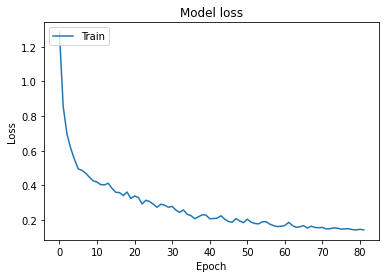

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# 推論

## ImageDataGenerator テストデータ定義

In [ ]:
# test 用
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
    # ,rescale=1./255    
    )

test_generator = test_datagen.flow_from_directory(
    TEST_FILE_PATH_A,
    # seed=0,
    shuffle = False, #シャッフルしない
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode=None)

Found 1651 images belonging to 1 classes.


## predict

In [ ]:
import pandas as pd

# ModelCHeckpoint(最良値の保存)
cp_path = OUTPUT_PATH + 'weight_' + STR_MODEL  + '_' + STR_ID + '.hdf5'
print(cp_path)

# 重みのロード
# model.load_weights(cp_path)

y_pred = model.predict_generator(test_generator)
print(y_pred)


# submitデータ作成

In [ ]:
print(len(y_pred))

result = []

for i in range(len(y_pred)):
  temp = list(y_pred[i])
  temp2 = temp.index(max(temp))
  # if temp2 != 0:
  #   temp2 = 1
  
  result.append(temp2)

print(result)

u, counts = np.unique(result, return_counts=True)

print(counts)

## submitデータ保存

In [ ]:
#現在時刻
now = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
print(now)

with open(OUTPUT_PATH + 'submit_BS' + str(BATCH_SIZE) + '_LR' + str(LEARNING_RATE) + '_EfnetB7'  + '_' + STR_ID + '_' + now.strftime('%m%d%H%M') + '.csv', 'w') as f:
  files = sorted(glob.glob(TEST_FILE_PATH_A + '*/*.jpg'))
  for i, file in enumerate(files):
      # ファイル名だけ抽出
      # temp_file = file.lstrip(TEST_FILE_PATH_A+'test_images/')
      temp_file = file.replace(TEST_FILE_PATH_A+'test_images/',"")
      # print("{}:file={}".format(i,temp_file))
      write_string=temp_file + ',' + str(int(result[i]))
      f.write(write_string+'\n')


# with open(output_path + 'submit_EfficientB7' + now.strftime('%m%d%H%M') + '.csv', 'w') as f:
#     for i in range(len(df_sample)):
#         write_string=df_sample.iloc[i]['Date'] + ',' + str(int(result.iloc[i]['Up']))
#         f.write(write_string+'\n')

2021-02-27 22:38:15.735584+09:00


## 確率データ保存

In [ ]:
with open(OUTPUT_PATH + 'Rate_BS' + str(BATCH_SIZE) + '_LR' + str(LEARNING_RATE) + '_EfnetB7' + '_' + STR_ID + '_' + now.strftime('%m%d%H%M') + '.csv', 'w') as f:
  files = sorted(glob.glob(TEST_FILE_PATH_A + '*/*.jpg'))
  for i, file in enumerate(files):
      # ファイル名だけ抽出
      # temp_file = file.lstrip(TEST_FILE_PATH_A+'test_images/')
      temp_file = file.replace(TEST_FILE_PATH_A+'test_images/',"")
      # print("{}:file={}".format(i,temp_file))
      write_string=temp_file + ',' + str(y_pred[i][0])+ ',' + str(y_pred[i][1])+ ',' + str(y_pred[i][2])+ ',' + str(y_pred[i][3])
      f.write(write_string+'\n')

In [ ]:
#終了時刻
finish_time = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
print("finish_time=",finish_time)
print("total_time=",finish_time-start_time)


finish_time= 2021-02-27 22:38:15.824990+09:00
total_time= 4:54:14.216706
